In [2]:
import matplotlib.pyplot as plt
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
import numpyro_stein.stein.kernels as kernels
from numpyro.infer.util import Predictive
from numpyro_stein.stein.autoguides import AutoDelta
from numpyro_stein.util import init_with_noise
from numpyro_stein.stein.stein import SVGD
from numpyro_stein.distributions.normal_mixture_distribution import NormalMixture
from numpyro_stein.stein.kernels import SteinKernel
from numpyro.infer import ELBO
from numpyro.infer.util import init_to_value
from tqdm import tqdm
import seaborn as sns
import os
import jax
import jax.numpy as np
from random import randint
import scipy.io

In [3]:
# From http://theoval.cmp.uea.ac.uk/matlab/default.html
data = scipy.io.loadmat('data/benchmarks.mat')

In [4]:
datasets = {k: {'train': {'input': v['x'][0, 0][v['train'][0, 0][13, :] - 1], 'class': (v['t'][0, 0][v['train'][0, 0][13, :] - 1] == 1).astype('float')[:, 0]}, 'test': {'input': v['x'][0, 0][v['test'][0, 0][13, :] - 1], 'class': (v['t'][0, 0][v['test'][0, 0][13, :] - 1] == 1).astype('float')[:, 0]}} for k, v in data.items() if not str.startswith(k, "__") and not k == 'benchmarks' and v['x'][0, 0].shape[0] > 500}

In [35]:
rng_key = jax.random.PRNGKey(randint(0, int(1e6)))
num_iterations = 3000
num_particles = 100

In [36]:
def model(data, classes=None):
    alpha = numpyro.sample('alpha', dist.InverseGamma(concentration=1.0, rate=0.01))
    w = numpyro.sample('w', dist.Normal(loc=np.zeros(data.shape[1]+1), scale=alpha))
    with numpyro.plate('data', data.shape[0]):
        biased_data = np.concatenate((np.ones((data.shape[0],1)), data), axis=1)
        return numpyro.sample('x', dist.Bernoulli(logits=biased_data @ w), obs=classes)

In [37]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value({'x': -10.}), noise_scale=1.0))

In [38]:
def test_accuracy(rng_key, testset, params, num_pred=100):
    def single_test_accuracy(rng_key, testset, params):
        guide_trace = handlers.trace(handlers.substitute(guide, params)).get_trace(testset['input'])
        model_trace = handlers.trace(handlers.replay(handlers.seed(model, rng_key), guide_trace)).get_trace(testset['input'])
        accuracy = np.count_nonzero(model_trace['x']['value'] == testset['class']) / testset['input'].shape[0] * 100
        return accuracy
    accs = []
    for i in range(num_particles):
        ps = {k: param[i] for k, param in params.items()}
        accs.append(jax.vmap(lambda rnk: single_test_accuracy(rnk, testset, ps))(jax.random.split(rng_key, num_pred)))
    return np.mean(np.stack(accs))

In [41]:
for name, dataset in datasets.items():
    print(name)
    svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=.05), ELBO(),
            kernels.RBFKernel(), num_stein_particles=num_particles,
            repulsion_temperature=dataset['train']['input'].shape[0] ** -1 * 0.01)
    svgd_state = svgd.init(rng_key, dataset['train']['input'], dataset['train']['class'])
    pbar = tqdm(range(num_iterations))
    for i in pbar:
        svgd_state, loss = svgd.update(svgd_state, dataset['train']['input'], dataset['train']['class'])
        pbar.set_description("SVGD: {}".format(loss))
    print(test_accuracy(svgd_state.rng_key, dataset['train'], svgd.get_params(svgd_state)))

banana
SVGD: 285.28118896484375:  28%|██▊       | 829/3000 [01:35<04:10,  8.66it/s]


KeyboardInterrupt: 

dict_keys(['banana', 'diabetis', 'german', 'image', 'ringnorm', 'splice', 'twonorm', 'waveform'])

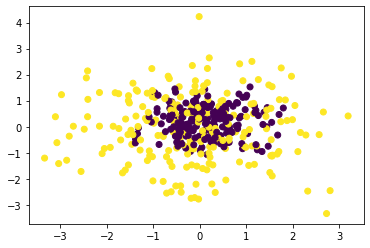

In [51]:
import matplotlib.pyplot as plt

plt.scatter(datasets['ringnorm']['train']['input'][:, 0], datasets['ringnorm']['train']['input'][:, 1], c=datasets['ringnorm']['train']['class'])
datasets.keys()